### 1st Virtual Methods Seminar: Methods of Computational Social Science
## Introduction to Social Network Science with Python
# Brokerage and Closure  - Exercise 3.1.3 (Solution)
Instructors: Haiko Lietz & Olga Zagovora

Date: September 23, 2020
## Packages

In [1]:
import sys
libs_path = '../../code/libs/'
sys.path.append(libs_path)
import compsoc as cs

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.manifold import MDS

## Copenhagen Networks Study: Multiplex interactions among 845 university students

In [3]:
users, genders, bluetooth, calls, sms, facebook_friends = cs.copenhagen_collection(path='../../data/copenhagen/')

In [4]:
bluetooth_first_day = bluetooth[bluetooth['day'] == 0]

In [5]:
bluetooth_first_day_max = bluetooth_first_day[['user_id_from', 'user_id_to', 'strength']].groupby(['user_id_from', 'user_id_to']).max().reset_index()

In [6]:
G = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='bluetooth_first_day_max', 
    node_list=users, 
    edge_list=bluetooth_first_day_max, 
    node_label='user'
)

Extract the largest connected component:

In [7]:
G = G.subgraph(max(nx.connected_components(G), key=len))

In [8]:
vp_node_pos = nx.spring_layout(G, seed=0)

In [9]:
vp_node_color = cs.partition_to_vertex_property(users['gender_id'], {0: '#e41a1c', 1: '#377eb8', 2: '#4daf4a'})

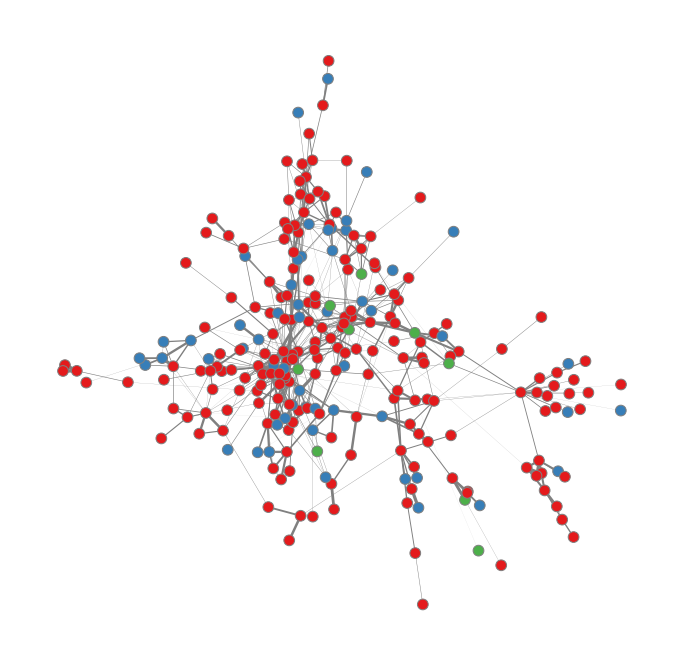

In [10]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_color=vp_node_color, 
    edge_width_factor=.05, 
    figsize='large'
)

## Brokerage and Closure
We will now compute standard measures for brokerage and closure. For later analytical purposes, all scores, will be stored in this dataframe:

In [11]:
nodes_scores = pd.DataFrame(index=list(G.nodes()))

### Node Centralities
Before we visit the algorithms for brokerage and closure: the number of neighbors of a node determines the extent to which a node can be embedded into an open or closed structure. The larger the degree, the more diverse a neighborhood and the larger a cohesive group can be.

In [12]:
degree = dict(nx.degree(G))

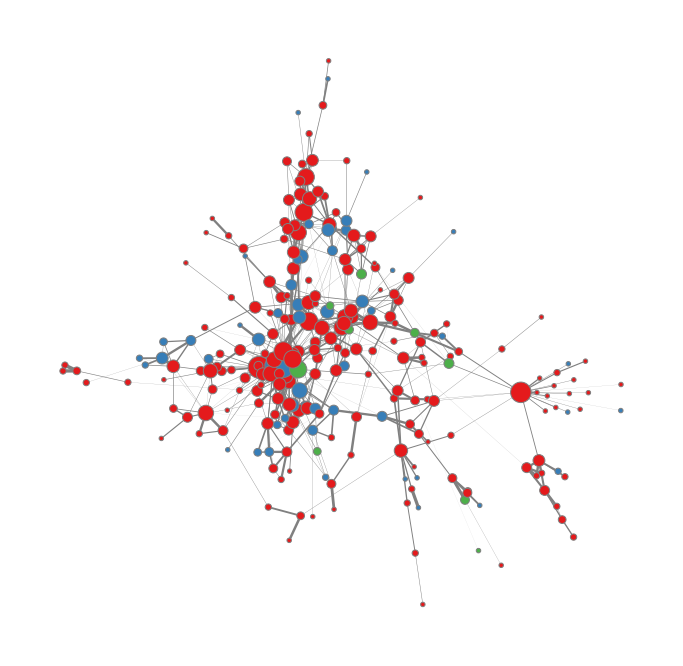

In [13]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_size=degree, 
    node_size_factor=20, 
    node_color=vp_node_color, 
    edge_width_factor=.05, 
    figsize='large'
)

In [14]:
nodes_scores.loc[:, 'degree'] = list(degree.values())

For the purpose of comparing node positional measures, we also compute the other two main centralities. Note that closeness and betweenness are global metrics that take the full graph into account:

In [15]:
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)

In [16]:
nodes_scores.loc[:, 'closeness'] = list(closeness.values())
nodes_scores.loc[:, 'betweenness'] = list(betweenness.values())

### Closure
#### Clustering coefficient
The clustering coefficient $CC(x)$ quantifies the **extent to which potential edges in a node’s neighborhood are realized**. It is a purely local measure, i.e., it only takes the immediate neighborhood of $x$ into account:

In [17]:
clustering = nx.clustering(G)

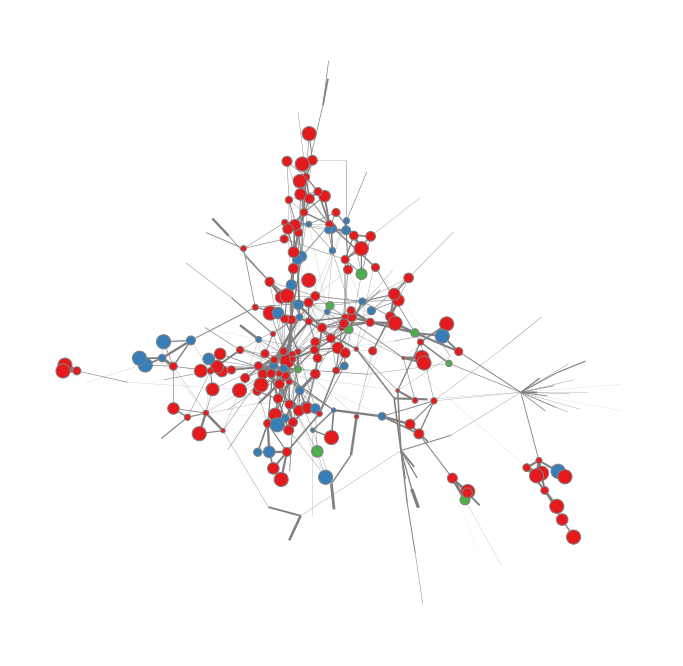

In [18]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_size=clustering, 
    node_size_factor=200, 
    node_color=vp_node_color, 
    edge_width_factor=.05, 
    figsize='large'
)

In [19]:
nodes_scores.loc[:, 'clustering'] = list(clustering.values())

#### Local efficiency
Node local efficiency $E(x)$ is a generalization of the clustering coefficient. It quantifies the **extent to which neighbors of a node x can reach each other if x was removed**. It is a purely local measure:

In [20]:
def node_local_efficiency(g):
    import itertools
    node_local_efficiency = {}
    for node in g.nodes():
        neighbors = g.adj[node]
        g_neighbors = g.subgraph(neighbors)
        local_efficiency = []
        for edge in itertools.combinations(list(g_neighbors.nodes), 2):
            local_efficiency.append(nx.efficiency(g_neighbors, edge[0], edge[1]))
        sum_local_efficiency = sum(local_efficiency)
        if sum_local_efficiency == 0:
            node_local_efficiency.update({node: 0})
        else:
            len_local_efficiency = len(local_efficiency)
            node_local_efficiency.update({node: sum_local_efficiency/len_local_efficiency})
    return node_local_efficiency

In [21]:
local_efficiency = node_local_efficiency(G)

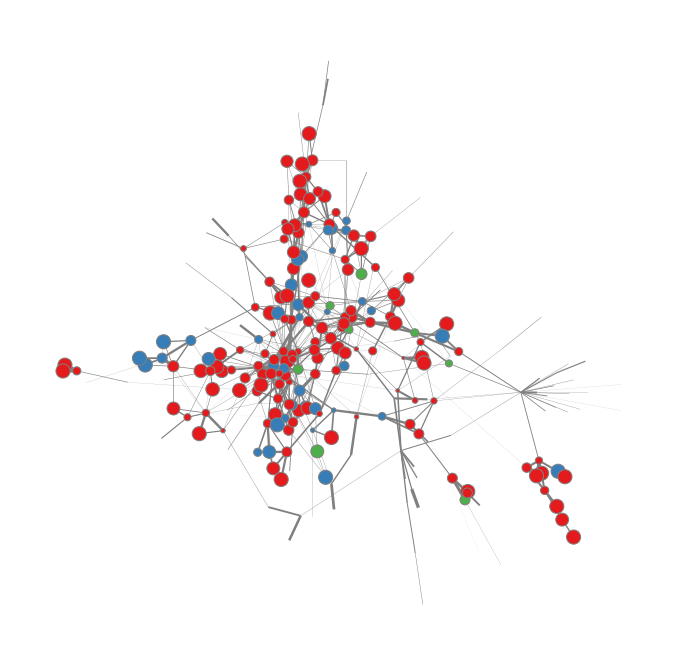

In [22]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_size=local_efficiency, 
    node_size_factor=200, 
    node_color=vp_node_color, 
    edge_width_factor=.05, 
    figsize='large'
)

In [23]:
nodes_scores.loc[:, 'local_efficiency'] = list(local_efficiency.values())

### Brokerage
#### Effective size
Effective size $L(x)$ quantifies the **extent to which a node's neighbors are not connected among themselves**. It is also a purely local measure:

In [24]:
effective_size = nx.effective_size(G)

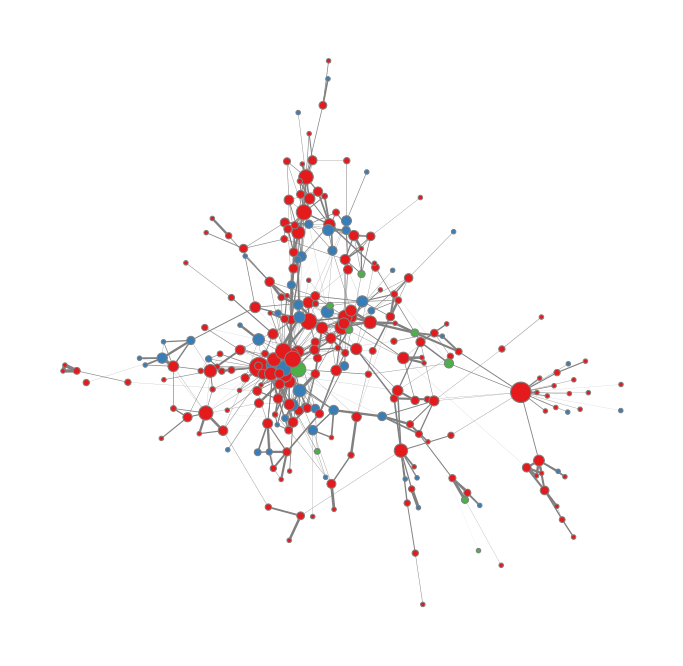

In [25]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_size=effective_size, 
    node_size_factor=20, 
    node_color=vp_node_color, 
    edge_width_factor=.05, 
    figsize='large'
)

In [26]:
nodes_scores.loc[:, 'effective_size'] = list(effective_size.values())

#### Constraint
Constraint $M(x)$ quantifies the **extent to which node x is invested in those neighbors that are themselves invested in the neighbors of x**. It uses the 2-hop environment of $x$:

In [27]:
constraint = nx.constraint(G)

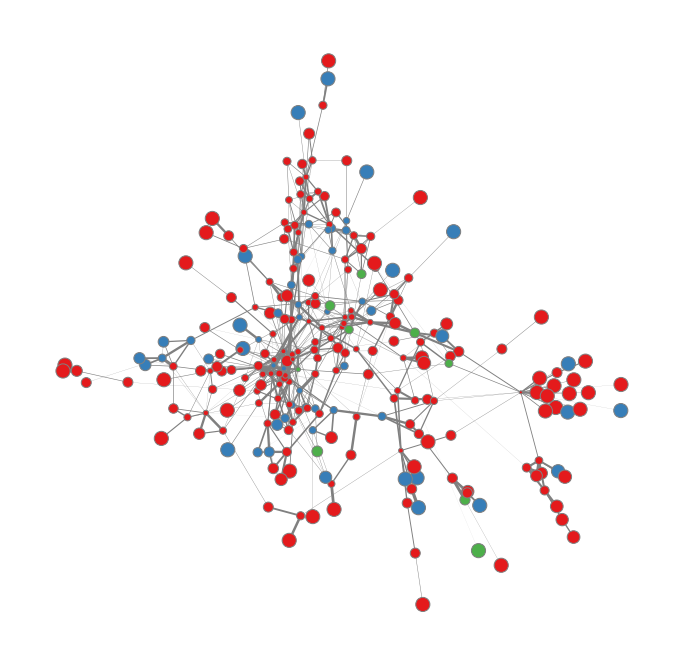

In [28]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_size=constraint, 
    node_size_factor=200, 
    node_color=vp_node_color, 
    edge_width_factor=.05, 
    figsize='large'
)

In [29]:
nodes_scores.loc[:, 'constraint'] = list(constraint.values())

#### Simmelian brokerage
Latora et al. (2013) argue for a new brokerage measure at the interface between the clustering coefficient and effective size. It quantifies the **extent to which a node acts as a broker between otherwise disconnected groops of densely connected nodes**. It is a purely local measure:

In [30]:
def simmelian_brokerage(g, degree=None, local_efficiency=None):
    if degree is None:
        degree = dict(nx.degree(G))
    if local_efficiency is None:
        local_efficiency = node_local_efficiency(G)
    
    return {node: degree[node]-(degree[node]-1)*local_efficiency[node] for node in local_efficiency}

In [31]:
simmelian_brokerage = simmelian_brokerage(G)

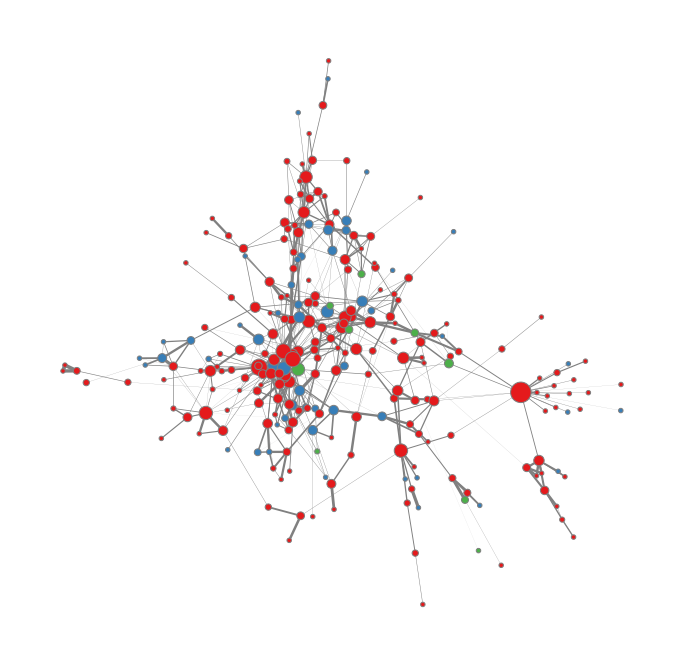

In [32]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_size=simmelian_brokerage, 
    node_size_factor=20, 
    node_color=vp_node_color, 
    edge_width_factor=.05, 
    figsize='large'
)

In [33]:
nodes_scores.loc[:, 'simmelian_brokerage'] = list(simmelian_brokerage.values())

## Analysis
We have computed standard measures for brokerage and closure:

In [34]:
nodes_scores.head()

,degree,closeness,betweenness,clustering,local_efficiency,effective_size,constraint,simmelian_brokerage
0,5,0.203470,0.001502,0.7,0.850000,2.2,0.455786,1.600000
513,2,0.200155,0.000898,0.0,0.000000,2.0,0.500000,2.000000
514,3,0.156174,0.000000,1.0,1.000000,1.0,0.750000,1.000000
3,6,0.251707,0.034006,0.4,0.533333,4.0,0.234741,3.333333
516,1,0.188596,0.000000,0.0,0.000000,1.0,1.000000,1.000000


Knowing about the mathematical relationship of clustering coefficient and effective size, we want to see how our measures differ in practice. With pandas, we can easily get the correlation matrix:

In [35]:
nodes_scores.corr()

,degree,closeness,betweenness,clustering,local_efficiency,effective_size,constraint,simmelian_brokerage
degree,1.000000,0.712334,0.704961,0.027018,0.200607,0.960115,-0.762428,0.883600
closeness,0.712334,1.000000,0.621428,0.012939,0.132138,0.678739,-0.716152,0.642594
betweenness,0.704961,0.621428,1.000000,-0.196814,-0.128790,0.787941,-0.524314,0.823660
clustering,0.027018,0.012939,-0.196814,1.000000,0.964171,-0.158128,-0.088245,-0.209026
local_efficiency,0.200607,0.132138,-0.128790,0.964171,1.000000,-0.004439,-0.223937,-0.103865
effective_size,0.960115,0.678739,0.787941,-0.158128,-0.004439,1.000000,-0.719332,0.965038
constraint,-0.762428,-0.716152,-0.524314,-0.088245,-0.223937,-0.719332,1.000000,-0.704246
simmelian_brokerage,0.883600,0.642594,0.823660,-0.209026,-0.103865,0.965038,-0.704246,1.000000


Correlations are only negative when the constraint measure is involved. Unlike all other brokerage metrics, it is not a measure of "opportunity". Since constraint is properly normalized, we can subtract it from 1 to arrive at such a more comparable brokerage measure:

In [36]:
nodes_scores['constraint'] = 1-nodes_scores['constraint']

We want to insights about which metrics produce similar results. Therefore, we use multidimensional scaling (MDS) to embed our data into a two-dimensional space. The algorithm of the sklearn package needs as input a dissimilarity matrix. The standard way to precompute dissimilarities from correlations is to subtract the latter from 1:

In [37]:
data = (1-nodes_scores.corr()).values

Now reduce dimensionality:

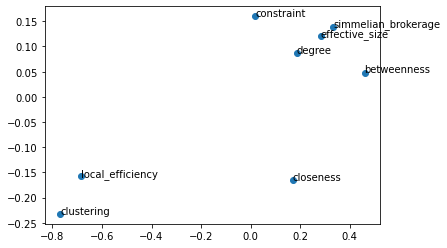

In [38]:
mds = MDS(n_components=2, random_state=3, dissimilarity='precomputed')
pos = mds.fit(data).embedding_
plt.scatter(pos[:, 0], pos[:, 1])
for i in range(0, len(nodes_scores.columns)):
    plt.text(pos[i, 0], pos[i, 1], nodes_scores.columns[i])

We see that clustering coefficient and its generalization, local efficiency, represent one group of metrics. From the literature we know that, in the limits of large data, these measures are inversely related to degree ([Ravasz & Barabási, 2003](https://doi.org/10.1103/PhysRevE.67.026112)). The other group consists of metrics that are more strongly correlated with degree (either positively or negatively, like constraint). Simmelian brokerage is strongly correlated with effective size. While the latter is mathematically related to the clustering coefficient, it is mathematically related to local efficiency. All these metrics are local ones. Constraint is constructed on a node's 2-hop environment. Due to this difference it is a viable alternative to quantifying brokerage opportunities. Betweenness is a global measure. The same is true for the global measure of betweenness centrality. Closeness, also a global measure, is somehow similar to all metrics and should not be used to measure brokerage or closure.

In [39]:
nodes_scores['effective_size']/nodes_scores['degree']

0      0.440000
513    1.000000
514    0.333333
3      0.666667
516    1.000000
         ...   
496    0.875000
502    0.750000
503    1.000000
506    0.820000
507    0.920000
Length: 259, dtype: float64

In [40]:
# solution using dictionary comprehension. it only works because the keys are identical in both dictionaries
effective_size_norm = {node: effective_size[node]/degree[node] for node in effective_size} # or:

# solution using pandas
#effective_size_norm = (nodes_scores['effective_size']/nodes_scores['degree']).reset_index(drop=True).to_dict()

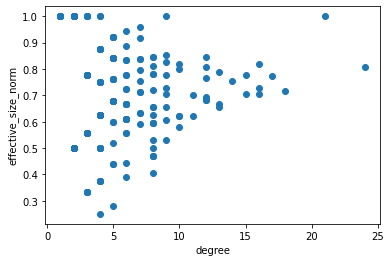

In [41]:
plt.scatter(degree.values(), effective_size_norm.values())
plt.xlabel('degree')
plt.ylabel('effective_size_norm')
plt.show()

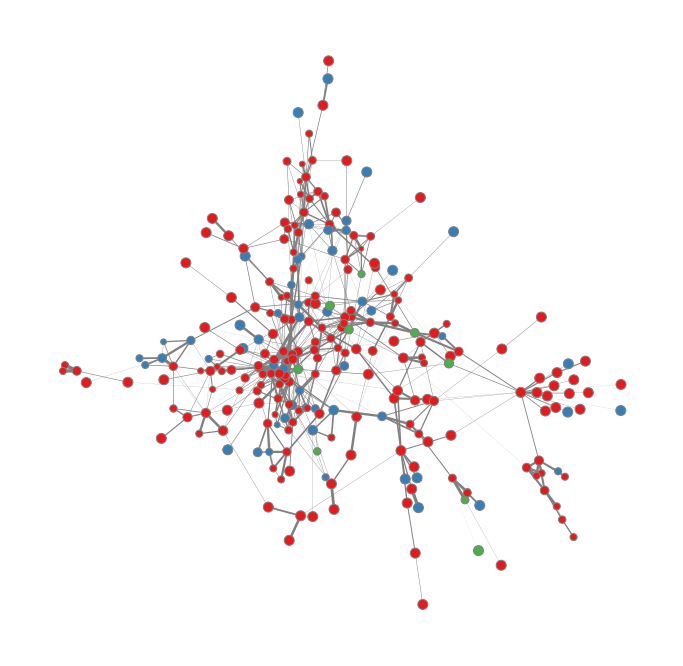

In [42]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_size=effective_size_norm, 
    node_size_factor=100, 
    node_color=vp_node_color, 
    edge_width_factor=.05, 
    figsize='large'
)